# Elderly Falls Prediction: Exploratory Data Analysis

## Research Question
"Can we develop a predictive model to identify elderly individuals at high risk of falls within the next 12 months based on their medical history, medication profiles, and functional assessment data?"

## Overview
This notebook contains the exploratory data analysis (EDA) for predicting falls risk in elderly individuals using the National Health and Aging Trends Study (NHATS) dataset. We will analyze data from Rounds 11-13 to understand patterns and develop initial predictive models.

### Data Sources
- NHATS Rounds 11-13
- Key files:
  - Sample Person (SP) Files: Main participant data
  - Tracker Files: Longitudinal tracking
  - Activity Files: Detailed activity data
  - Accelerometer Files: Movement data

### Analysis Goals
1. Understand data structure and quality
2. Identify key variables for falls prediction
3. Analyze relationships between variables
4. Develop baseline prediction model
5. Generate insights for feature engineering

## Setup and Data Loading

For this initial EDA phase, we will focus on:
1. Data cleaning and quality assessment
2. Basic feature engineering
3. Exploratory visualizations
4. Baseline model development

Note: Full model development and optimization will be conducted in Module 24.

In [26]:
# Essential imports for initial EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For baseline model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight

#For data loading
from zipfile import ZipFile
from io import BytesIO

# Settings
plt.style.use('default')  # Use default style instead of seaborn
sns.set_style("whitegrid")  # Set seaborn style directly
%matplotlib inline

# Set figure size for better readability
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

## Data Loading and Initial Assessment

We'll start with Round 13 (most recent) Sample Person file to:
1. Understand data structure
2. Identify relevant variables for falls prediction
3. Assess data quality
4. Plan cleaning steps

In [27]:
# Load most recent round
#sp_r13 = pd.read_stata('data/NHATS_Round_13_SP_File.dta')

with ZipFile('data/NHATS_Round_13_SP_File.zip') as zf:
    with zf.open('NHATS_Round_13_SP_File.dta') as f:
        sp_r13 = pd.read_stata(BytesIO(f.read()))

# Basic information
print("Dataset Shape:", sp_r13.shape)
print("\nColumns:", len(sp_r13.columns))
print("\nSample of columns:")
print(sp_r13.columns[:10].tolist())

Dataset Shape: (8597, 1516)

Columns: 1516

Sample of columns:
['spid', 'r13dlmlint', 'r13dresid', 'r12dresid', 'r11dresid', 'r10dresid', 'r9dresid', 'r8dresid', 'r7dresid', 'r6dresid']


## Data Quality Assessment and Variable Selection

First, let's identify and examine key variables related to:
1. Falls history and risk
2. Health conditions
3. Functional assessments
4. Demographics

We'll analyze:
- Missing values
- Data distributions
- Variable relationships
- Potential data quality issues

In [23]:
# Function to find relevant variables
def find_relevant_vars(df, keywords):
    """Find columns containing specified keywords."""
    relevant_vars = {}
    for keyword in keywords:
        matches = [col for col in df.columns if keyword.lower() in col.lower()]
        relevant_vars[keyword] = matches
    return relevant_vars

# Keywords for different variable categories
keywords = ['fl', 'fall', 'health', 'walk', 'mobil', 'medic', 'age', 'gender', 'race']

# Find relevant variables
relevant_vars = find_relevant_vars(sp_r13, keywords)

# Display falls-related variables first
print("Falls-related variables:")
for var in relevant_vars['fl'] + relevant_vars['fall']:
    print(f"- {var}")

# Basic data quality check for these variables
falls_vars = relevant_vars['fl'] + relevant_vars['fall']
print("\nMissing value analysis for falls-related variables:")
print(sp_r13[falls_vars].isnull().sum())

# Display value distributions for falls variables
print("\nValue distributions for falls-related variables:")
for var in falls_vars:
    print(f"\n{var}:")
    print(sp_r13[var].value_counts())

Falls-related variables:
- fl13newsample
- fl13pt2miss
- fl13spdied
- re13newblgfl
- fl13structure
- fl13resnew
- fl13facility
- fl13hotype
- fl13retirecom
- fl13notalert
- fl13notmobile
- hc13fllsinmth
- fl13noonetalk
- ho13levelsflr
- fl13bathgrbbr
- fl13bathseat
- fl13raisedtlt
- fl13tltgrbbr
- fl13cane
- fl13walker
- fl13wheelchr
- fl13whlchrhom
- fl13scooter
- fl13scooterhm
- fl13deaf
- fl13blind
- mo13oflvslepr
- fl13didntleav
- fl13ntlvrmslp
- dm13flag
- fl13drives
- fl13drvlstyr
- fl13dneverdrv
- fl13showering
- fl13takingbth
- fl13washingup
- ds13flag
- fl13sdmissing
- pe13flruppain
- pe13sideflrup
- fl13lefthand
- fl13righthand
- fl13eiherhand
- fl13lftgrptst
- fl13rhtgrptst
- fl13charstnds
- fl13balstands
- fl13wlkingrse
- pk13pkarfl1ef
- pk13pkarfl1rs
- pk13pkarfl1rd
- pk13pkarfl2ef
- pk13pkarfl2rs
- pk13pkarfl2rd
- hc13worryfall
- hc13multifall
- rh13impfall

Missing value analysis for falls-related variables:
fl13newsample    0
fl13pt2miss      0
fl13spdied       0
re13ne

## Initial Data Visualization

Let's create some visualizations to understand:
1. Distribution of falls incidents
2. Relationship between falls and key health indicators
3. Demographic patterns in falls risk

Processing falls data...

Prepared data for hc13fllsinmth:
hc13fllsinmth
1.0    1012
2.0    6988
Name: count, dtype: int64


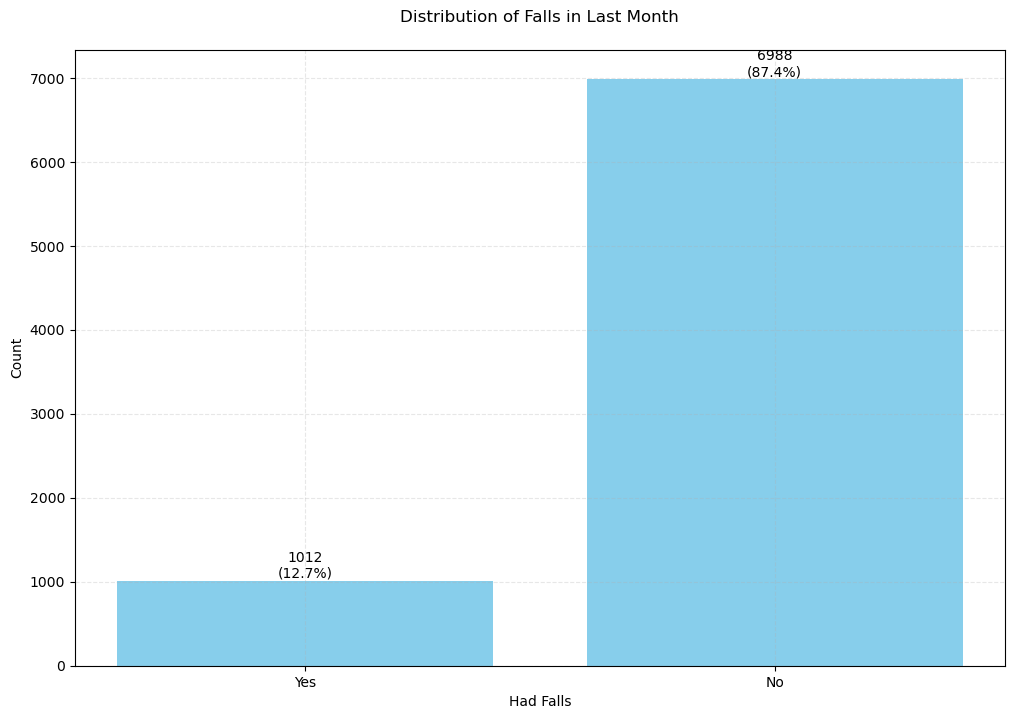


Processing worry data...

Prepared data for hc13worryfall:
hc13worryfall
1.0    2790
2.0    5208
Name: count, dtype: int64


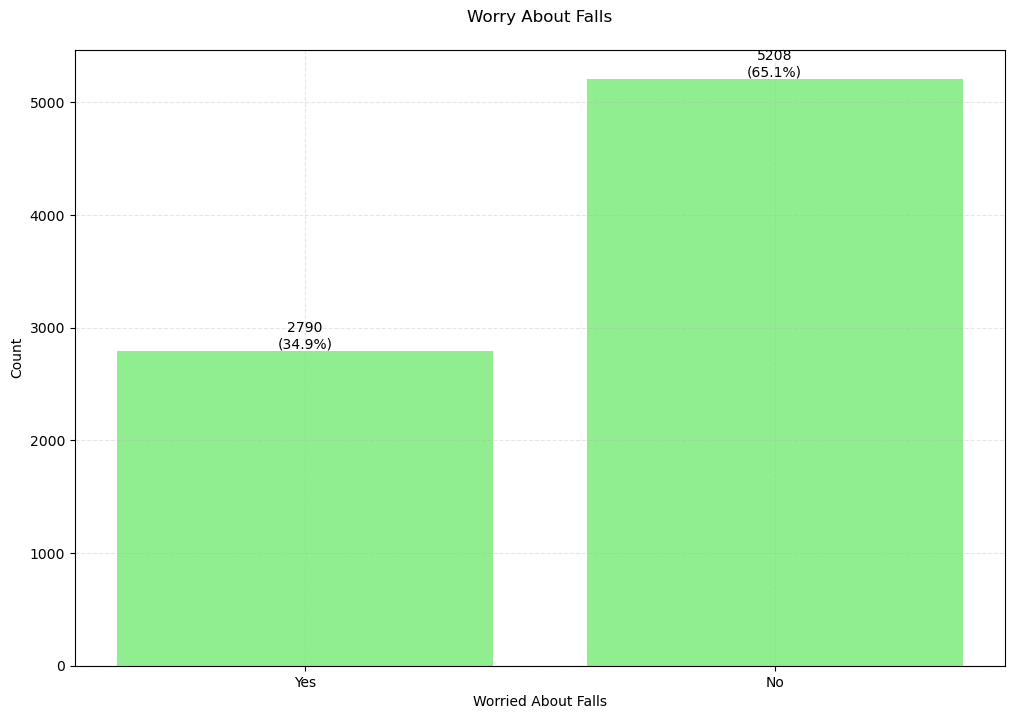


Processing multiple falls data...

Prepared data for hc13multifall:
hc13multifall
1.0    1324
2.0    1471
Name: count, dtype: int64


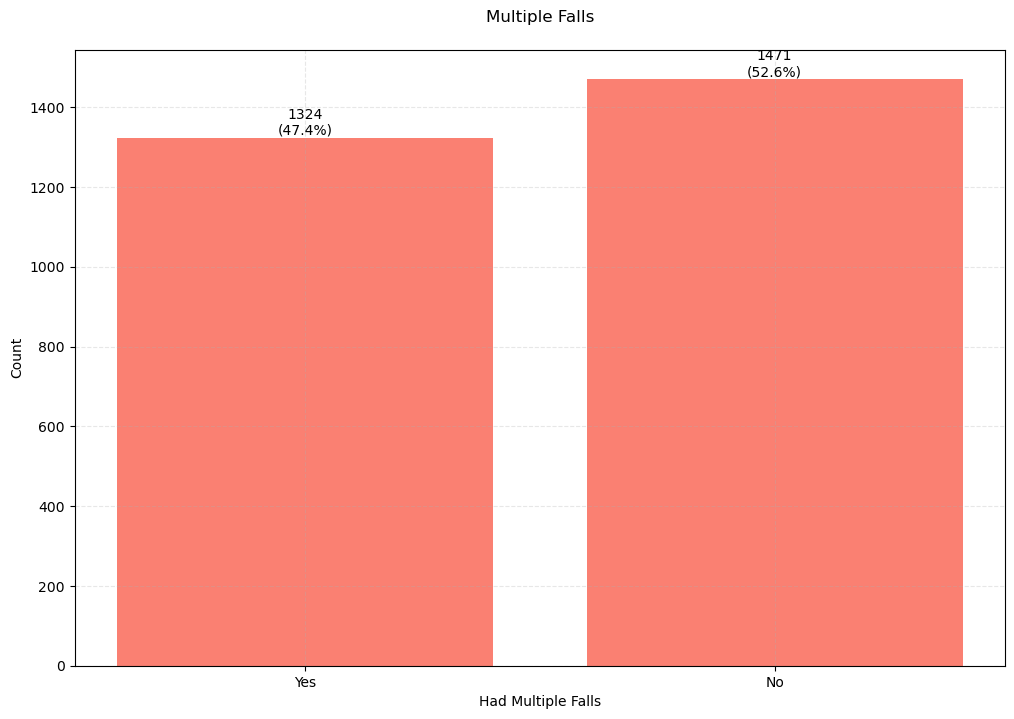


Processing mobility aids data...

Mobility aids counts:
     Aid Type  Count
0        Cane   1863
1      Walker   1615
2  Wheelchair    769


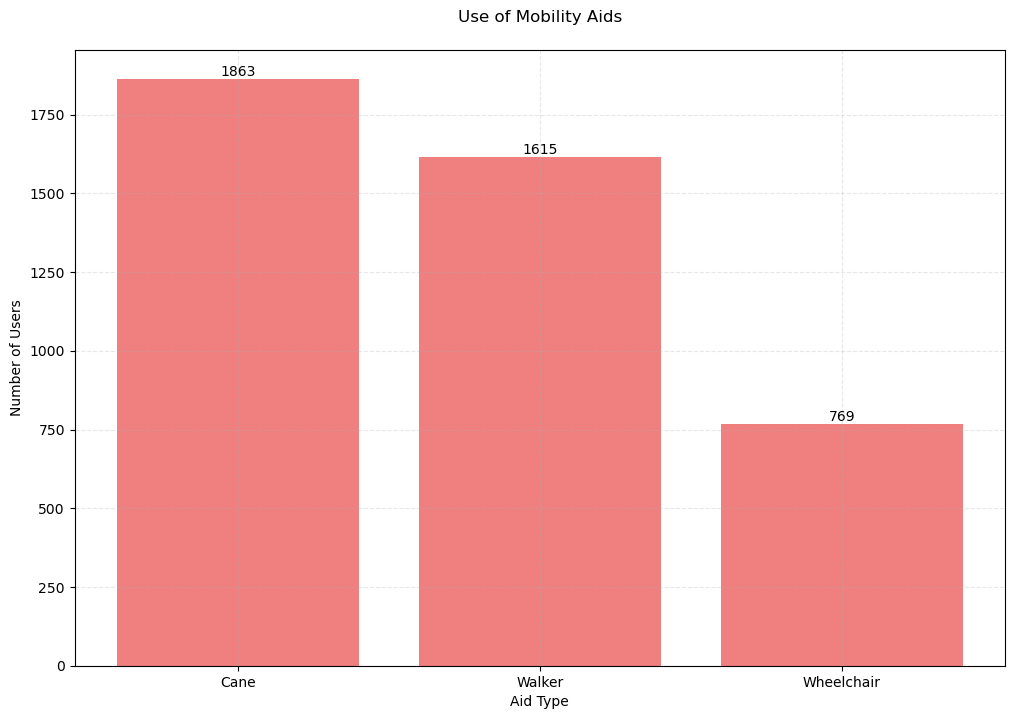


Final data verification (with percentages):

Falls distribution:
Yes: 1012 (12.7%)
No: 6988 (87.4%)

Worry distribution:
Yes: 2790 (34.9%)
No: 5208 (65.1%)

Multiple falls distribution:
Yes: 1324 (47.4%)
No: 1471 (52.6%)


In [24]:
# Set style for better-looking plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 8]  # Slightly larger figures
plt.rcParams['figure.dpi'] = 100

# Plot 1: Falls Distribution with percentages
print("Processing falls data...")
plt.figure()
falls_counts = prepare_data(sp_r13['hc13fllsinmth'], 'hc13fllsinmth')
total = falls_counts.sum()
percentages = (falls_counts / total) * 100

plt.bar(['Yes', 'No'], falls_counts.values, color='skyblue')
# Add percentage labels on top of bars
for i, (count, percentage) in enumerate(zip(falls_counts.values, percentages)):
    plt.text(i, count, f'{count}\n({percentage:.1f}%)',
             ha='center', va='bottom')
plt.title('Distribution of Falls in Last Month', pad=20)
plt.xlabel('Had Falls')
plt.ylabel('Count')
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

# Plot 2: Worry About Falls with percentages
print("\nProcessing worry data...")
plt.figure()
worry_counts = prepare_data(sp_r13['hc13worryfall'], 'hc13worryfall')
total = worry_counts.sum()
percentages = (worry_counts / total) * 100

plt.bar(['Yes', 'No'], worry_counts.values, color='lightgreen')
for i, (count, percentage) in enumerate(zip(worry_counts.values, percentages)):
    plt.text(i, count, f'{count}\n({percentage:.1f}%)',
             ha='center', va='bottom')
plt.title('Worry About Falls', pad=20)
plt.xlabel('Worried About Falls')
plt.ylabel('Count')
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

# Plot 3: Multiple Falls with percentages
print("\nProcessing multiple falls data...")
plt.figure()
multi_counts = prepare_data(sp_r13['hc13multifall'], 'hc13multifall')
total = multi_counts.sum()
percentages = (multi_counts / total) * 100

plt.bar(['Yes', 'No'], multi_counts.values, color='salmon')
for i, (count, percentage) in enumerate(zip(multi_counts.values, percentages)):
    plt.text(i, count, f'{count}\n({percentage:.1f}%)',
             ha='center', va='bottom')
plt.title('Multiple Falls', pad=20)
plt.xlabel('Had Multiple Falls')
plt.ylabel('Count')
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

# Plot 4: Mobility Aids with percentages
print("\nProcessing mobility aids data...")
plt.figure()
mobility_aids = pd.DataFrame({
    'Aid Type': ['Cane', 'Walker', 'Wheelchair'],
    'Count': [
        sum(pd.to_numeric(sp_r13['fl13cane'].astype(str).str[0], errors='coerce') == 1),
        sum(pd.to_numeric(sp_r13['fl13walker'].astype(str).str[0], errors='coerce') == 1),
        sum(pd.to_numeric(sp_r13['fl13wheelchr'].astype(str).str[0], errors='coerce') == 1)
    ]
})
print("\nMobility aids counts:")
print(mobility_aids)

plt.bar(mobility_aids['Aid Type'], mobility_aids['Count'], color='lightcoral')
# Add count labels on top of bars
for i, count in enumerate(mobility_aids['Count']):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.title('Use of Mobility Aids', pad=20)
plt.xlabel('Aid Type')
plt.ylabel('Number of Users')
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

# Print final verification with percentages
print("\nFinal data verification (with percentages):")
for name, counts in [("Falls", falls_counts), ("Worry", worry_counts), ("Multiple falls", multi_counts)]:
    total = counts.sum()
    percentages = (counts / total) * 100
    print(f"\n{name} distribution:")
    for value, count in counts.items():
        print(f"{'Yes' if value == 1 else 'No'}: {count} ({percentages[value]:.1f}%)")

Target variable distribution:
falls_target
0    7585
1    1012
Name: count, dtype: int64

Mobility aid usage distribution:
uses_any_mobility_aid
0    5699
1    2898
Name: count, dtype: int64

Training set class distribution:
falls_target
0    6067
1     810
Name: count, dtype: int64

Test set class distribution:
falls_target
0    1518
1     202
Name: count, dtype: int64

Training balanced logistic regression model...

Model Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.67      0.78      1518
           1       0.20      0.62      0.31       202

    accuracy                           0.67      1720
   macro avg       0.57      0.65      0.54      1720
weighted avg       0.85      0.67      0.73      1720


Confusion Matrix:
[[1023  495]
 [  76  126]]

ROC AUC Score: 0.6963451779960604

Feature Importance:
                 Feature  Importance
0  uses_any_mobility_aid    0.771533
1          hc13worryfall    0.647

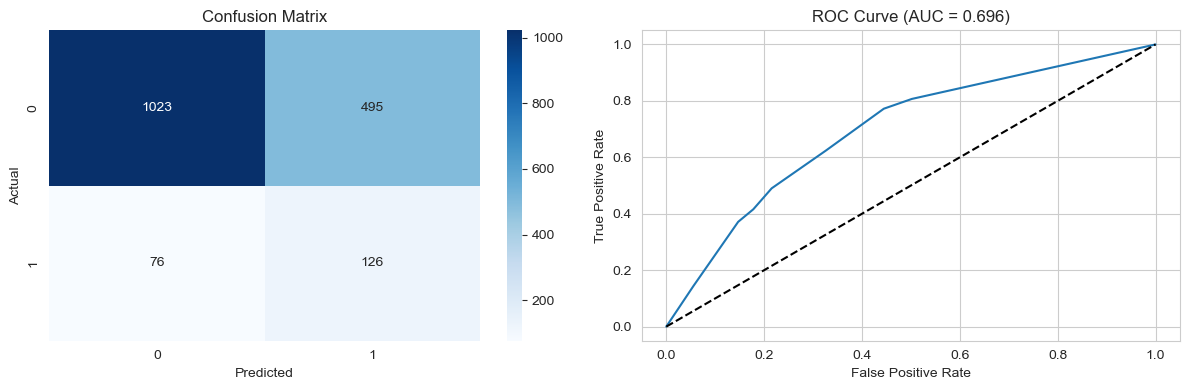


Model Interpretation:
1. Class Distribution:
Total samples: 8597
Falls (Class 1): 1012 (11.8%)
No Falls (Class 0): 7585 (88.2%)

2. Model Performance Summary:
- ROC AUC Score: 0.696
- Sensitivity (True Positive Rate): 0.624
- Specificity (True Negative Rate): 0.674


In [19]:
# First, create a copy of the dataframe to avoid fragmentation
sp_r13_model = sp_r13.copy()

# Create mobility aid features step by step
cane_use = (pd.to_numeric(sp_r13['fl13cane'].astype(str).str[0], errors='coerce') == 1)
walker_use = (pd.to_numeric(sp_r13['fl13walker'].astype(str).str[0], errors='coerce') == 1)
wheelchair_use = (pd.to_numeric(sp_r13['fl13wheelchr'].astype(str).str[0], errors='coerce') == 1)

# Combine mobility aid features
uses_any_mobility_aid = (cane_use | walker_use | wheelchair_use).astype(int)

# Create falls target
falls_target = (pd.to_numeric(sp_r13['hc13fllsinmth'].astype(str).str[0], errors='coerce') == 1).astype(int)

# Add new features to the model DataFrame
sp_r13_model['uses_any_mobility_aid'] = uses_any_mobility_aid
sp_r13_model['falls_target'] = falls_target

# Verify the data structure
print("Target variable distribution:")
print(sp_r13_model['falls_target'].value_counts())
print("\nMobility aid usage distribution:")
print(sp_r13_model['uses_any_mobility_aid'].value_counts())

# Select features for baseline model with more predictors
features = [
    'uses_any_mobility_aid',
    'hc13worryfall',      # worry about falls
    'pe13flruppain',      # pain indicator
    'fl13balstands',      # balance indicator
    'fl13charstnds',      # chair stands indicator
    'fl13wlkingrse'       # walking indicator
]

# Prepare features and target
X = sp_r13_model[features].copy()
y = sp_r13_model['falls_target']

# Clean features (replace special codes with NaN)
for col in X.columns:
    # Convert to string and extract first character properly
    if col != 'uses_any_mobility_aid':  # Skip the already processed binary column
        X[col] = X[col].apply(lambda x: str(x)[0] if pd.notnull(x) else x)
        X[col] = pd.to_numeric(X[col], errors='coerce')
        # Replace special codes (-1, -7, -8, -9) with NaN
        X[col] = X[col].replace([-1, -7, -8, -9], np.nan)

# Simple imputation (median for numeric)
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Ensure target variable has no missing values
mask = ~y.isna()
X_imputed = X_imputed[mask]
y = y[mask]

# Split data with stratification to handle class imbalance
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # This ensures both train and test have same proportion of samples for each class
)

# Print class distribution after splitting
print("\nTraining set class distribution:")
print(pd.Series(y_train).value_counts())
print("\nTest set class distribution:")
print(pd.Series(y_test).value_counts())

# Use class weights to handle imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),  # Explicitly specify the classes
    y=y_train
)
class_weight_dict = dict(zip([0, 1], class_weights))

# Train baseline model with balanced class weights
print("\nTraining balanced logistic regression model...")
model = LogisticRegression(
    random_state=42,
    class_weight=class_weight_dict,
    max_iter=1000  # Increase max iterations to ensure convergence
)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("\nModel Evaluation:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Feature importance
importance = pd.DataFrame({
    'Feature': features,
    'Importance': abs(model.coef_[0])
})
print("\nFeature Importance:")
print(importance.sort_values('Importance', ascending=False))

# Add model performance visualization
plt.figure(figsize=(12, 4))

# Plot 1: Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot 2: ROC Curve
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')

plt.tight_layout()
plt.show()

# Print interpretation
print("\nModel Interpretation:")
print("1. Class Distribution:")
print(f"Total samples: {len(y)}")
print(f"Falls (Class 1): {sum(y == 1)} ({sum(y == 1)/len(y)*100:.1f}%)")
print(f"No Falls (Class 0): {sum(y == 0)} ({sum(y == 0)/len(y)*100:.1f}%)")

print("\n2. Model Performance Summary:")
print(f"- ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.3f}")
print(f"- Sensitivity (True Positive Rate): {conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]):.3f}")
print(f"- Specificity (True Negative Rate): {conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1]):.3f}")